### Import the Libraries

In [57]:
import os
import math
import pandas as pd
import numpy as np

import librosa
import librosa.display

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow.keras as keras
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.python.keras import regularizers

data_path = '../audio_data_MFCC/6_segs_per_track_output.npz'

### Load and prepare the data

In [58]:
def load_data (dataset_path, data1 = 'mfcc', data2 = 'labels'):
    
    np_file = np.load(dataset_path)
    
    return np_file[data1], np_file[data2]

In [59]:
def prepare_datasets(data_path, test_size, validation_size):
    
    # load data
    X, y = load_data(data_path, 'mfcc', 'labels')
    
    # create train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    
    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, 
                                                                    y_train, 
                                                                    test_size=validation_size)
    
    
    X_train = X_train[..., np.newaxis] # 4d array -> (num_samples, 130, 13, 1)
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test
    

In [60]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets('../audio_data_MFCC/6_segs_per_track_output.npz', 0.25, 0.2)

### Define and build the model

In [61]:
def build_model(input_shape):

    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.BatchNormalization())
    
    # 3rd conv layer
    model.add(keras.layers.Conv2D(16, (1, 1), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    return model

In [62]:
X_train.shape

(3595, 216, 13, 1)

### Build and Compile The Model

In [63]:
# build CNN model
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape)

In [64]:
# compile model
optimizer = keras.optimizers.Adam(learning_rate = 0.00015)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Add in an early stop to avoid overtraining

In [65]:
early_stop = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=25)

In [66]:
history = model.fit(X_train, 
          y_train, 
          validation_data = (X_validation, y_validation), 
          batch_size = 64, 
          epochs = 150,
          )

Epoch 1/150
57/57 [==============================] - 13s 210ms/step - loss: 3.5473 - accuracy: 0.1182 - val_loss: 3.1243 - val_accuracy: 0.0957
Epoch 2/150
57/57 [==============================] - 11s 195ms/step - loss: 3.2601 - accuracy: 0.1510 - val_loss: 2.9493 - val_accuracy: 0.2380
Epoch 3/150
57/57 [==============================] - 11s 189ms/step - loss: 3.0691 - accuracy: 0.1953 - val_loss: 2.8038 - val_accuracy: 0.3103
Epoch 4/150
57/57 [==============================] - 16s 278ms/step - loss: 2.9058 - accuracy: 0.2416 - val_loss: 2.7013 - val_accuracy: 0.3281
Epoch 5/150
57/57 [==============================] - 15s 257ms/step - loss: 2.8362 - accuracy: 0.2733 - val_loss: 2.6307 - val_accuracy: 0.3359
Epoch 6/150
57/57 [==============================] - 17s 293ms/step - loss: 2.7591 - accuracy: 0.2790 - val_loss: 2.5157 - val_accuracy: 0.3838
Epoch 7/150
57/57 [==============================] - 17s 292ms/step - loss: 2.6788 - accuracy: 0.2977 - val_loss: 2.4737 - val_accuracy:

57/57 [==============================] - 17s 297ms/step - loss: 1.2285 - accuracy: 0.6882 - val_loss: 1.2152 - val_accuracy: 0.7141
Epoch 58/150
57/57 [==============================] - 16s 286ms/step - loss: 1.2389 - accuracy: 0.6844 - val_loss: 1.2202 - val_accuracy: 0.6986
Epoch 59/150
57/57 [==============================] - 16s 286ms/step - loss: 1.1980 - accuracy: 0.6954 - val_loss: 1.2077 - val_accuracy: 0.7186
Epoch 60/150
57/57 [==============================] - 16s 284ms/step - loss: 1.2667 - accuracy: 0.6722 - val_loss: 1.1861 - val_accuracy: 0.7141
Epoch 61/150
57/57 [==============================] - 17s 294ms/step - loss: 1.1653 - accuracy: 0.7045 - val_loss: 1.1524 - val_accuracy: 0.7297
Epoch 62/150
57/57 [==============================] - 16s 289ms/step - loss: 1.2011 - accuracy: 0.6968 - val_loss: 1.2982 - val_accuracy: 0.6663
Epoch 63/150
57/57 [==============================] - 16s 288ms/step - loss: 1.1879 - accuracy: 0.7067 - val_loss: 1.2326 - val_accuracy: 0.676

57/57 [==============================] - 17s 294ms/step - loss: 0.8918 - accuracy: 0.7867 - val_loss: 0.8888 - val_accuracy: 0.8042
Epoch 114/150
57/57 [==============================] - 17s 298ms/step - loss: 0.8108 - accuracy: 0.8115 - val_loss: 0.8885 - val_accuracy: 0.8009
Epoch 115/150
57/57 [==============================] - 17s 293ms/step - loss: 0.8341 - accuracy: 0.8032 - val_loss: 0.8763 - val_accuracy: 0.8087
Epoch 116/150
57/57 [==============================] - 16s 280ms/step - loss: 0.7357 - accuracy: 0.8408 - val_loss: 0.8718 - val_accuracy: 0.8087
Epoch 117/150
57/57 [==============================] - 16s 281ms/step - loss: 0.7703 - accuracy: 0.8370 - val_loss: 0.8143 - val_accuracy: 0.8209
Epoch 118/150
57/57 [==============================] - 16s 280ms/step - loss: 0.7580 - accuracy: 0.8397 - val_loss: 0.9890 - val_accuracy: 0.7686
Epoch 119/150
57/57 [==============================] - 16s 282ms/step - loss: 0.7422 - accuracy: 0.8466 - val_loss: 0.9624 - val_accuracy:

In [79]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

47/47 [==============================] - 1s 20ms/step - loss: 0.7870 - accuracy: 0.8244 0s - loss: 0.7850 - accuracy: 0.


### Plot the Model

In [90]:
def plot_history(history):
    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error Eval")

    plt.show()

AttributeError: 'DataFrame' object has no attribute 'history'

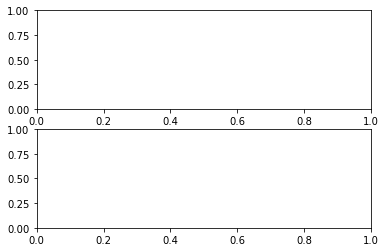

In [91]:
plot_history(history)

### Predict the Model

In [ ]:
def predict(model, X_prediction, y_prediction):
    
    X_temp = X[np.newaxis, ...]
    
    # Plot predictions to a 2D Array
    predictions = model.predict(X_temp)
    
    predicted_index = np.argmax(predictions, axis=1)
    
    print(f'Target: {y}, Predicted label: {predicted_index}')

In [97]:
X_prediction = X_test[200]
y_prediction = y_test[200]

In [101]:
predict(model, X_prediction, y_prediction)

Target: 9, Predicted label: [9]


In [ ]:
model.save('../models/cnn_model_6_segs_per_track.h5')